# Information about the repository QOSQ Previous Challenges.


# Parameter Shift Rule Derivation using Qiskit and validate with Pennylane 

## Find the lowest eigenvalue of the followinf matrix:

I will use Qiskit for the implementation.
At the beggining I just need to calculate the gradient descent in the circuit and compare them with the pennylane library.

## Background:

First we need to understand the problem in order to tackle it in teh best way. I will begin showing what it is a VQE (Variational Quantum Eigensolver). How we can implement parameter quantum circuits and expectations values. At the end, how can we optimze the parameters in order to find the value or the expected behaviour.  

Variational Theorem:  
If you are familiar with hamiltonians and expectations values. You will find that the eigenvalue attach many interest in many research areas, in particular we are interested into the lowest value in the hamiltonian. The variational theorem states that:  

$$  \langle \psi | \hat{H} | \psi \rangle  = \lambda_1 \ge \lambda_0 $$

This equation tell us that any evaluation (expectation value) of a random state $\psi$ in our hamiltonian will be greater or equal to the lowest eigenvalue possible of my hamiltonian. Lets assume that we parametrized the state $ \psi $, now the equation has the following form:

$$  \langle \psi(\theta) | \hat{H} | \psi(\theta) \rangle  = \lambda_1 \ge \lambda_0 $$

In principle, the problem is still the same as before, but now we can modify the parameter $\theta$ in order to find the eigenvalue. Now, we need to introduce the concept of parametrized quantum circuit. As you know (or maybe not) the quantum circuits can be parametrized in order to modify some gates. The perfect gates to do this are the $RX$, $RY$, $RZ$ and, the control version of this three gates which are $CRX$, $CRY$, $CRZ$ or any linear combination of theses. This will help us to created our $\theta$ state.  

The second step is to evaluate the quantum state with our hamiltonian. The hamiltonian is consider that main part of our research, becouse we need to deal with it in a very carefull way to reduce some complexity. For our problem our hamiltonian is very simple but take care when you are planing to deal with a bigger one.  

This is our hamiltonian to find the lowest eigenvalue.  

$$

\begin{equation}
\begin{bmatrix}
    0 & 0 & 0 & 0 \\
    0 & -1 & 1 & 0 \\
    0 & 1 & -1 & 0 \\
    0 & 0 & 0 & 0 \\
\end{bmatrix}  
\end{equation}

$$

If you carefully this is a non-unitary matrix. This can be anoying at the moment to insert into a quantum circuit.Becouse we work with unitary transformations. Nevertheless, a very interesting properties about the expectation value is that this is linear, such as:

$$  \langle \psi(\theta) | \hat{H} | \psi(\theta) \rangle  = \langle \psi(\theta) | \hat{H}_1+\hat{H}_2 | \psi(\theta) \rangle =  \langle \psi(\theta) | \hat{H}_1 | \psi(\theta) \rangle +  \langle \psi(\theta) | \hat{H}_2 | \psi(\theta) \rangle $$

Now we can convert our non-unitary matrix into two separete unitary matrices. Caviat; this is not the only way to convert this matrix into a unitary.

$$

\begin{equation}
\begin{bmatrix}
    0 & 0 & 0 & 0 \\
    0 & -1 & 1 & 0 \\
    0 & 1 & -1 & 0 \\
    0 & 0 & 0 & 0 \\
\end{bmatrix} =

\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & -1 & 0 & 0 \\
    0 & 0 & -1 & 0 \\
    0 & 0 & 0 & 1 \\
\end{bmatrix} +

\begin{bmatrix}
    -1 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 0 & -1 \\
\end{bmatrix}  
\end{equation}

$$

Perfect, now our matrix in divide into two unitary matrices. Now in order to optimize the quantum parameters to find the lowest eigenvalue we need to find the gradient of our quantum circuit with respect to the parameters. Maybe you are wonder, how can I achieve this? In the resource section you will find a more detail explanation [1], here a I will give you the short part.  

We will build something call the Parameter-Shift Rule in order to find the derivate in our circuit with certain parameters. So, lets assume we have $N$ parameters in our quantum circuit and we want to find the derivate/gradient in the $N_i$. With the parameter-shift rule we need only evaluate our circuit in the following way:

$$  \nabla_i  \langle \psi(\theta_i) | \hat{H} | \psi(\theta_i) \rangle = \frac{1}{2} [ \langle \psi(\theta_i+\frac{\pi}{2}) | \hat{H} | \psi(\theta_i+\frac{\pi}{2}) \rangle - \langle \psi(\theta_i-\frac{\pi}{2}) | \hat{H} | \psi(\theta_i-\frac{\pi}{2}) \rangle ] $$

As you can see we are evaluating the quantum circuit and calculating the expectation value just moving one parameter at the time and the other are constant. With this tecnique we just need to iterate for all the parameters and we will get all the gradients for all the points. With the gradient we can apply a simply gradient descent algorithm to find the lowest value in our hamiltonian as follow:

$$ \theta_{new} = \theta_{old} - l*\nabla_i \langle \hat{H} \rangle $$

Finally, just iterate many times to find the lowest eigenvalue!

## Resources:
[1] Parameter Shift-Rule: https://pennylane.ai/qml/demos/tutorial_backprop.html

## Comments:
- Remember that the just need the gradient in the circuit to calculate the values.
- Remember the order of the operators.

### Importing

We will work with Qiskit and Pennylane. Pennylane is a very focus framework to work with Quantum Machine Learning projects.in the other hand, Qiskit is more friendly and it is used for most student when are involved in the quantum computing world. We will use qiskit to build the circuit a test the problem and pennylane to corroborate our problem and results.

In [1]:
from qiskit import QuantumCircuit, Aer, execute, QuantumRegister, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator
from qiskit.opflow import CircuitStateFn, CircuitOp
import numpy as np
import matplotlib.pyplot as plt

We need a quantum circuit with just 2 qubits. Why? because our operator (matrix) is a 4x4 matrix which is $2^n$ x $2^n$ where $n$ is the number of qubits. Solving this we have that $n$ must be equal to 2. 

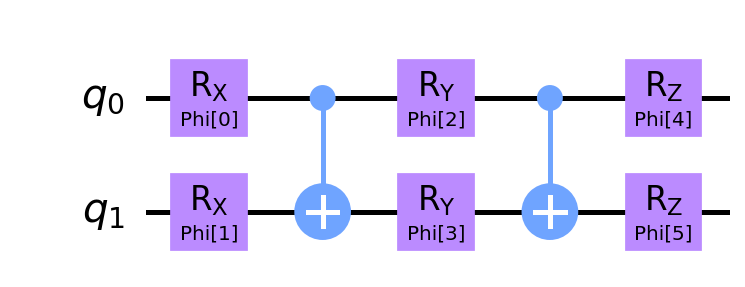

In [2]:
phi = ParameterVector('Phi',6)

qc = QuantumCircuit(2)
qc.rx(phi[0],0)
qc.rx(phi[1],1)
qc.cnot(0,1)
qc.ry(phi[2],0)
qc.ry(phi[3],1)
qc.cnot(0,1)
qc.rz(phi[4],0)
qc.rz(phi[5],1)

qc.draw('mpl', scale=2.5)

In principle, your circuit can have the quantum gates that you want as long as has parameters and also a varierity of them. Depending of the problem itself the number of the parameters can increased, but careful to use to many parameters which this will be the quantum circuit more complex and slowly to evaluate expectation values.  
The next function will calculate the expectation value given a initial parameters and operators for a given quantum circuit. I will explain each line in detail.

In [3]:
def ShiftRuleV3(qc, initial_values, operators : list):

    num_para = qc.num_parameters
    num_qubits = qc.num_qubits

    operators_list = []

    ### Convert the matrices into operators using qiskit functions.
    for k in range(len(operators)):
        Opt = Operator(operators[k])
        operators_list.append(CircuitOp(Opt.to_instruction()))

    ### Expectation Value Calculation ###
    # First we assign the parameters and calculate the expectation value.
    qc_normal = qc.bind_parameters({phi:initial_values})
    psi_normal = CircuitStateFn(qc_normal)

    exp_value = 0.0
    # Here we iterate over the different operators.
    for k in range(len(operators)):
        exp_value += psi_normal.adjoint().compose(operators_list[k]).compose(psi_normal).eval().real

    gradients = []
    ### Gradient Calculation ###
    for i in range(num_para):

        exp_value_plus = 0.0
        exp_value_minus = 0.0

        actual_parameter = initial_values
        actual_parameter[i] = actual_parameter[i] + np.pi/2

        qc_plus = qc.bind_parameters({phi:actual_parameter})

        actual_parameter[i] = actual_parameter[i] - np.pi

        qc_minus = qc.bind_parameters({phi:actual_parameter})

        psi_plus = CircuitStateFn(qc_plus)
        psi_minus = CircuitStateFn(qc_minus)

        for k in range(len(operators)):
            exp_value_plus += psi_plus.adjoint().compose(operators_list[k]).compose(psi_plus).eval().real
            exp_value_minus += psi_minus.adjoint().compose(operators_list[k]).compose(psi_minus).eval().real

        gradients.append(0.5*(exp_value_plus-exp_value_minus))

        actual_parameter[i] = actual_parameter[i] + np.pi/2

    return exp_value, np.array(gradients)

### Solving the problem

In [9]:
initial = np.array([0.37454012, 0.95071431, 0.67454012, 0.45071431, 0.25071431, 0.75071431])
#initial = np.array([0.5,0.5,0.5,0.5,0.5,0.5])
#initial = np.random.random(6)

I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0, -1j],[1j, 0]])
Z = np.array([[1,0],[0,-1]])

#U = np.kron(np.kron(Z,I),Y)

U1 = np.array([[1,0,0,0],
     [0,-1,0,0],
     [0,0,-1,0],
     [0,0,0,1]])

U2 = np.array([[-1,0,0,0],
     [0,0,1,0],
     [0,1,0,0],
     [0,0,0,-1]])

R1 = np.kron(I,I)
R2 = np.kron(X,X)
R3 = np.kron(Y,Y)
R4 = np.kron(Z,Z)

eigen_val = np.linalg.eigvals(U1+U2)
print("Eigenvalues: {}".format(eigen_val))

H = [U1, U2]
#H = [-R1, R2, R3, R4]

exp_value, gradient = ShiftRuleV3(qc, initial,H)
print("Initial Parameters: {}".format(initial))
print("Initial Expectation Value: {}".format(exp_value))
print("Initial Gradient Values: {}".format(gradient))

Eigenvalues: [ 0. -2.  0.  0.]
Initial Parameters: [0.37454012 0.95071431 0.67454012 0.45071431 0.25071431 0.75071431]
Initial Expectation Value: -0.09125348550048962
Initial Gradient Values: [-0.05948042 -0.07455684  0.06623967 -0.17180918  0.18112438 -0.18112438]


In [10]:
def Optimizer(qc, initial_values, operators, lr, epochs):

    initial = initial_values
    exp_values = []

    for i in range(epochs):
        exp, grad = ShiftRuleV3(qc, initial,operators)
        exp_values.append(exp)
        initial = initial - lr*grad
        
    return exp_values

Lowest Value: -1.9999981834066167


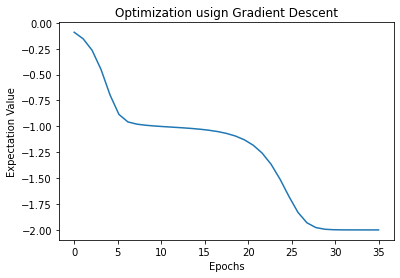

In [12]:
epochs = 35

epochs_line = np.linspace(0,epochs, epochs)
lr = 0.5

exp_value = Optimizer(qc, initial,H, lr, epochs)

print("Lowest Value: {}".format(exp_value[-1]))
plt.plot(epochs_line, exp_value)
plt.ylabel("Expectation Value")
plt.xlabel("Epochs")
plt.title("Optimization usign Gradient Descent")
plt.show()

# Comparison with Pennylane

In [17]:
# here we are just using the same value for all the parameters.
initial = np.array([0.5,0.5,0.5,0.5,0.5,0.5])

# MEasure the Z @ Z operator for simplicity.
H = [R4]

exp_value, gradient = ShiftRuleV3(qc, initial,H)
print("Initial Parameters: {}".format(initial))
print("Initial Expectation Value: {}".format(exp_value))

Initial Parameters: [0.5 0.5 0.5 0.5 0.5 0.5]
Initial Expectation Value: 0.6758712218347047


In [18]:
# Pennylane implementations:
from pennylane import numpy as np
import pennylane as qml

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RX(params[0], wires=1)

    qml.CNOT(wires=[0,1])

    qml.RY(params[0], wires=0)
    qml.RY(params[0], wires=1)

    qml.CNOT(wires=[0,1])

    qml.RZ(params[0], wires=0)
    qml.RZ(params[0], wires=1)

    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [19]:
par = np.array([0.5], requires_grad=True)

circuit(par)

tensor(0.67587122, requires_grad=True)

### Excelent! There are the same values. With this code you can generalize the parameter shift rule for any number of qubits.